In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import sklearn.metrics as sm
from sklearn.metrics import PredictionErrorDisplay
from sklearn.tree import export_graphviz

from IPython.display import Image
import pydotplus
import os
import six
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
def display_prediction_error(y_test, y_pred, feature="Redshift"):
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=axs[0]
    )
    axs[0].set_title(f"Actual vs. Predicted {feature}")
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        ax=axs[1]
    )
    axs[1].set_title(f"Residuals vs. Predicted {feature}")
    plt.tight_layout()
    plt.show()

def calculate_RSME(model, X_train, y_train, cv=3):
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)

    return np.sqrt(np.mean(np.absolute(scores)))


<h1>Feature Engineering and Data Cleaning

In [3]:
# converts name to GW###### format for visualization purposes
def simplify_name(name):
    if str.startswith(name, "GW"):
        return "GW" + name[2:8]
    return "GW" + name[0:6]

# extracts version number from name
def extract_version(name):
    return name[-1:]

# extracts confidence from catalog.shortName
def extract_group(shortname):
    if "2.1" in shortname:
        return shortname[9:]
    return shortname[7:]

# gets confidence number of group
def extract_confidence(group):
    if group == "confident":
        return 3
    if group == "marginal":
        return 2
    if group == "auxiliary":
        return 1
    return 0

O3_all = pd.read_csv("../Data/GWTC-3.csv")
O3_all["simple_name"] = np.array([simplify_name(name) for name in O3_all["name"]])
O3_all["group"] = np.array([3 for _ in range(O3_all["name"].size)])
O3_all["catalog"] = np.array([extract_group(shortname) for shortname in O3_all["catalog.shortName"]])
O3_all["confidence"] = np.array([extract_confidence(group) for group in O3_all["catalog"]])
O3_all["group_name"] = np.array(["O" + str(group) for group in O3_all["group"]])
O3_all = O3_all[["name", "simple_name", "catalog", "confidence", "version", "group_name", "group", "GPS", "far", "network_matched_filter_snr", "mass_1_source", "mass_2_source", "chirp_mass_source", "redshift", "luminosity_distance", "p_astro", "chi_eff"]]
O3_all = O3_all.rename(columns={"p_astro": "prob", "chi_eff": "effective_spin", "network_matched_filter_snr": "snr", "GPS": "gps", "mass_1_source": "mass1", "mass_2_source": "mass2", "chirp_mass_source": "chirp_mass", "combined_far": "far"})

O2_confident = pd.read_csv("../Data/GWTC-2_1-confident.csv")
O2_confident["simple_name"] = np.array([simplify_name(name) for name in O2_confident["name"]])
O2_confident["group"] = np.array([2 for _ in range(O2_confident["name"].size)])
O2_confident["group_name"] = np.array(["O" + str(group) for group in O2_confident["group"]])
O2_confident["catalog"] = np.array([extract_group(shortname) for shortname in O2_confident["catalog.shortName"]])
O2_confident["confidence"] = np.array([extract_confidence(group) for group in O2_confident["catalog"]])
O2_confident = O2_confident[["name", "simple_name", "catalog", "confidence", "version", "group_name", "group", "GPS", "far", "network_matched_filter_snr", "mass_1_source", "mass_2_source", "chirp_mass_source", "redshift", "luminosity_distance", "p_astro", "chi_eff"]]
O2_confident = O2_confident.rename(columns={"p_astro": "prob", "chi_eff": "effective_spin", "network_matched_filter_snr": "snr", "GPS": "gps", "mass_1_source": "mass1", "mass_2_source": "mass2", "chirp_mass_source": "chirp_mass", "combined_far": "far"})

O2_marginal = pd.read_csv("../Data/GWTC-2_1-marginal.csv")
O2_marginal["simple_name"] = np.array([simplify_name(name) for name in O2_marginal["name"]])
O2_marginal["group"] = np.array([2 for _ in range(O2_marginal["name"].size)])
O2_marginal["group_name"] = np.array(["O" + str(group) for group in O2_marginal["group"]])
O2_marginal["catalog"] = np.array([extract_group(shortname) for shortname in O2_marginal["catalog.shortName"]])
O2_marginal["confidence"] = np.array([extract_confidence(group) for group in O2_marginal["catalog"]])
O2_marginal = O2_marginal[["name", "simple_name", "catalog", "confidence", "version", "group_name", "group", "GPS", "far", "network_matched_filter_snr", "mass_1_source", "mass_2_source", "chirp_mass_source", "redshift", "luminosity_distance", "p_astro", "chi_eff"]]
O2_marginal = O2_marginal.rename(columns={"p_astro": "prob", "chi_eff": "effective_spin", "network_matched_filter_snr": "snr", "GPS": "gps", "mass_1_source": "mass1", "mass_2_source": "mass2", "chirp_mass_source": "chirp_mass", "combined_far": "far"})

O2_auxiliary = pd.read_csv("../Data/GWTC-2_1-auxiliary.csv")
O2_auxiliary["simple_name"] = np.array([simplify_name(name) for name in O2_auxiliary["name"]])
O2_auxiliary["group"] = np.array([2 for _ in range(O2_auxiliary["name"].size)])
O2_auxiliary["group_name"] = np.array(["O" + str(group) for group in O2_auxiliary["group"]])
O2_auxiliary["catalog"] = np.array([extract_group(shortname) for shortname in O2_auxiliary["catalog.shortName"]])
O2_auxiliary["confidence"] = np.array([extract_confidence(group) for group in O2_auxiliary["catalog"]])
O2_auxiliary = O2_auxiliary[["name", "simple_name", "catalog", "confidence", "version", "group_name", "group", "GPS", "far", "network_matched_filter_snr", "mass_1_source", "mass_2_source", "chirp_mass_source", "redshift", "luminosity_distance", "p_astro", "chi_eff"]]
O2_auxiliary = O2_auxiliary.rename(columns={"p_astro": "prob", "chi_eff": "effective_spin", "network_matched_filter_snr": "snr", "GPS": "gps", "mass_1_source": "mass1", "mass_2_source": "mass2", "chirp_mass_source": "chirp_mass", "combined_far": "far"})

O1_all = pd.read_csv("../Data/GWTC-1.csv")
O1_all["simple_name"] = np.array([simplify_name(name) for name in O1_all["name"]])
O1_all["group"] = np.array([1 for _ in range(O1_all["name"].size)])
O1_all["catalog"] = np.array([extract_group(shortname) for shortname in O1_all["catalog.shortName"]])
O1_all["confidence"] = np.array([extract_confidence(group) for group in O1_all["catalog"]])
O1_all["group_name"] = np.array(["O" + str(group) for group in O1_all["group"]])
O1_all = O1_all[["name", "simple_name", "catalog", "confidence", "version", "group_name", "group", "GPS", "far", "network_matched_filter_snr", "mass_1_source", "mass_2_source", "chirp_mass_source", "redshift", "luminosity_distance", "p_astro", "chi_eff"]]
O1_all = O1_all.rename(columns={"p_astro": "prob", "chi_eff": "effective_spin", "network_matched_filter_snr": "snr", "GPS": "gps", "mass_1_source": "mass1", "mass_2_source": "mass2", "chirp_mass_source": "chirp_mass", "combined_far": "far"})

observations = O3_all
observations = observations.append(O2_confident)
observations = observations.append(O2_marginal)
observations = observations.append(O2_auxiliary)
observations = observations.append(O1_all)

observations["total_mass"] = observations["mass1"] + observations["mass2"]
observations["mass_ratio"] = observations["mass2"] / observations["mass1"]
observations["mass_dos"] = abs(observations["mass2"] - observations["mass1"]) / observations["total_mass"]

observations["is_O1"] = observations["group"] == 1
observations["is_O2"] = observations["group"] == 2
observations["is_O3"] = observations["group"] == 3

confident = observations[observations['confidence'] == 3]

C:\Users\lucas\AppData\Local\Temp\ipykernel_18360\190026269.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  observations = observations.append(O2_confident)
C:\Users\lucas\AppData\Local\Temp\ipykernel_18360\190026269.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  observations = observations.append(O2_marginal)
C:\Users\lucas\AppData\Local\Temp\ipykernel_18360\190026269.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  observations = observations.append(O2_auxiliary)
C:\Users\lucas\AppData\Local\Temp\ipykernel_18360\190026269.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  observations = observations.append(O1_all)


<h1>Pre-processing

In [4]:
train, test, y_train, y_test = train_test_split(confident[confident["group"] == 3], confident[confident["group"] == 3]['luminosity_distance'], test_size=0.20, random_state=13)

In [5]:
model1 = RandomForestRegressor(random_state=13)

model1.fit(train[["snr", "far", "chirp_mass", "total_mass", "mass_ratio", "mass_dos", "effective_spin"]], y_train)

y_pred = model1.predict(test[["snr", "far", "chirp_mass", "total_mass", "mass_ratio", "mass_dos", "effective_spin"]])

print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 4))
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 4))
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 4))
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_pred), 3))

Mean absolute error = 378.1286
Mean squared error = 220494.7757
Median absolute error = 303.7
Explain variance score = 0.83
R2 score = 0.807


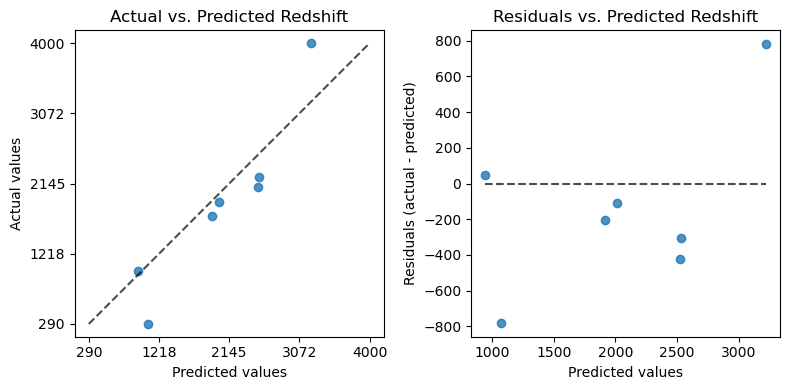

In [6]:
display_prediction_error(y_test=y_test, y_pred=y_pred)

In [7]:
feature_names = ["snr", "far", "chirp_mass", "total_mass", "mass_ratio", "mass_dos", "effective_spin"]

importances = model1.feature_importances_

std = np.std([tree.feature_importances_ for tree in model1.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(feature_names)):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:0.2f})")

Feature ranking:
1. snr (0.35)
2. total_mass (0.30)
3. chirp_mass (0.20)
4. effective_spin (0.06)
5. far (0.04)
6. mass_ratio (0.03)
7. mass_dos (0.02)


In [8]:
feature_names = ["snr", "effective_spin", "far", "chirp_mass", "total_mass"]

control_RSME = calculate_RSME(RandomForestRegressor(random_state=13), train[feature_names], y_train, RepeatedKFold(n_splits=3, n_repeats=100, random_state=13))
print("Base")
print(f"RSME {control_RSME:0.4f}")
print()

for feature in feature_names:
    without_feature = feature_names.copy()
    without_feature.remove(feature)
    no_feature_RSME = calculate_RSME(RandomForestRegressor(random_state=13), train[without_feature], y_train, RepeatedKFold(n_splits=3, n_repeats=100, random_state=13))
    print(f"No {feature}")
    print(f"RSME {no_feature_RSME:0.4f}")
    print(f"Diffrence {no_feature_RSME - control_RSME:0.4f}")
    print()

Base
RSME 1102.4021

No snr
RSME 1244.2453
Diffrence 141.8432

No effective_spin
RSME 1080.9660
Diffrence -21.4361

No far
RSME 1093.1809
Diffrence -9.2212

No chirp_mass
RSME 1070.1584
Diffrence -32.2437

No total_mass
RSME 1098.5444
Diffrence -3.8577



In [9]:
feature_names = ["snr", "chirp_mass", "total_mass"]

control_RSME = calculate_RSME(RandomForestRegressor(random_state=13), train[feature_names], y_train, RepeatedKFold(n_splits=3, n_repeats=100, random_state=13))
print("Base")
print(f"RSME {control_RSME:0.4f}")
print()

for feature in feature_names:
    without_feature = feature_names.copy()
    without_feature.remove(feature)
    no_feature_RSME = calculate_RSME(RandomForestRegressor(random_state=13), train[without_feature], y_train, RepeatedKFold(n_splits=3, n_repeats=100, random_state=13))
    print(f"No {feature}")
    print(f"RSME {no_feature_RSME:0.4f}")
    print(f"Diffrence {no_feature_RSME - control_RSME:0.4f}")
    print()

    only_feature_RSME = calculate_RSME(RandomForestRegressor(random_state=13), train[[feature]], y_train, RepeatedKFold(n_splits=3, n_repeats=100, random_state=13))
    print(f"Only {feature}")
    print(f"RSME {only_feature_RSME:0.4f}")
    print(f"Diffrence {only_feature_RSME - control_RSME:0.4f}")
    print()

Base
RSME 1066.1075

No snr
RSME 1538.2791
Diffrence 472.1716

Only snr
RSME 1679.5376
Diffrence 613.4301

No chirp_mass
RSME 1018.7199
Diffrence -47.3875

Only chirp_mass
RSME 1639.1742
Diffrence 573.0667

No total_mass
RSME 1042.8614
Diffrence -23.2461

Only total_mass
RSME 1530.7300
Diffrence 464.6225



In [10]:
model2 = RandomForestRegressor(random_state=13)

model2.fit(train[["snr", "total_mass"]], y_train)

y_pred = model2.predict(test[["snr", "total_mass"]])

print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 4))
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 4))
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 4))
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_pred), 3))

Mean absolute error = 316.0143
Mean squared error = 129098.6614
Median absolute error = 291.3
Explain variance score = 0.9
R2 score = 0.887


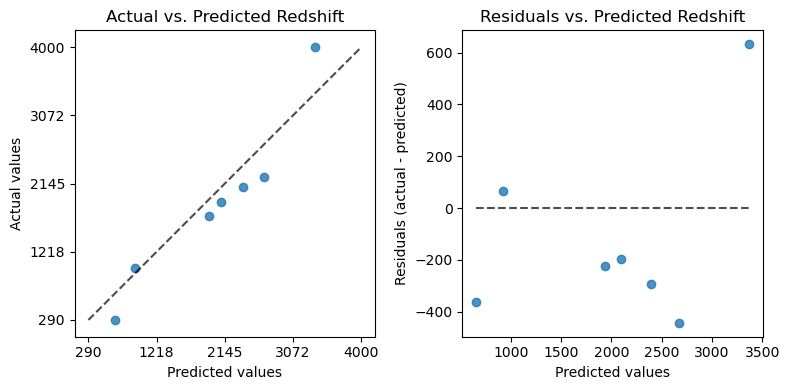

In [11]:
display_prediction_error(y_test=y_test, y_pred=y_pred)

<h1>Additional Architectures

In [12]:
models = [RandomForestRegressor(random_state=13), SVR(), BayesianRidge(), LinearRegression(), ElasticNet(random_state=13), XGBRegressor(random_state=13)]
model_names = ["Random Forest", "Support Vector", "Bayesian Ridge", "Linear Regression", "Elastic Net", "XG Boost"]

train_norm = MinMaxScaler().fit_transform(train[["snr", "total_mass"]])

for model, name in zip(models, model_names):
    model_RSME = calculate_RSME(model, train_norm, y_train, RepeatedKFold(n_splits=3, n_repeats=100, random_state=13))
    print(name)
    print(f"RSME {model_RSME:0.4f}")
    print()

Random Forest
RSME 1020.8794

Support Vector
RSME 1971.1537

Bayesian Ridge
RSME 1022.6900

Linear Regression
RSME 1033.7904

Elastic Net
RSME 1671.5793

XG Boost
RSME 1200.8771



<h1>Hyper-parameter Tuning

In [13]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

train_X_norm = X_scaler.fit_transform(train[["snr", "total_mass"]])
train_y_norm = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1))

test_X_norm = X_scaler.transform(test[["snr", "total_mass"]])
test_y_norm = y_scaler.transform(np.array(y_test).reshape(-1, 1))

<b>Random Forest

In [14]:
random_grid = {
    'max_depth': np.arange(2,5,1),
    'n_estimators':np.arange(50,300,10),
    'min_samples_leaf': np.arange(1,6,1),
    'min_samples_split': np.arange(2,10,1),
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
    'bootstrap': [True]
}

rf = RandomForestRegressor(random_state=13)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=500, cv=3, verbose=2, n_jobs=-1, random_state=13)

random_search.fit(train_X_norm, train_y_norm)

random_search.best_params_

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'n_estimators': 50,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 4,
 'criterion': 'absolute_error',
 'bootstrap': True}

In [15]:
model3 = random_search.best_estimator_

model3.fit(train_X_norm, train_y_norm)

y_pred = y_scaler.inverse_transform(model3.predict(test_X_norm).reshape(-1, 1))

print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 4)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 4)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 4)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred), 3))

Mean absolute error = 344.1143
Mean squared error = 200418.4029
Median absolute error = 356.8
Explain variance score = 0.83
R2 score = 0.825


c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


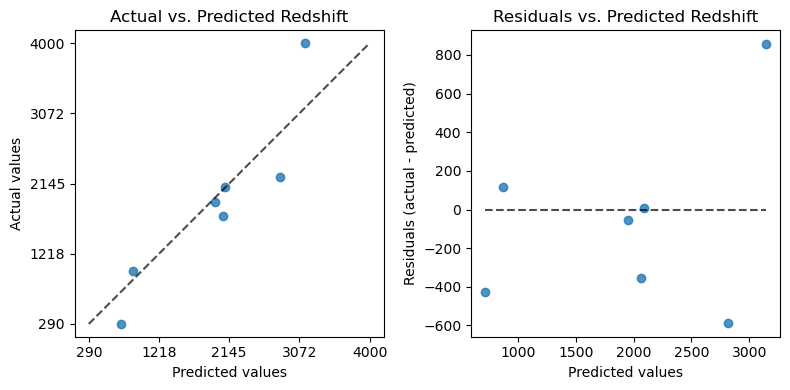

In [16]:
display_prediction_error(y_test=y_test, y_pred=y_pred.reshape(-1))

In [17]:
search_grid = {
    'max_depth': [3, 4],
    'n_estimators': np.arange(50,300,10),
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse']
}

rf = RandomForestRegressor(random_state=13)

grid_search = GridSearchCV(estimator=rf, param_grid=search_grid, cv=RepeatedKFold(n_splits=3, n_repeats=3, random_state=13), verbose=2, n_jobs=-1)

grid_search.fit(train[["snr", "total_mass"]], y_train)

grid_search.best_params_

Fitting 9 folds for each of 600 candidates, totalling 5400 fits


{'criterion': 'absolute_error',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 170}

In [18]:
model4 = grid_search.best_estimator_

model4.fit(train_X_norm, train_y_norm)

y_pred = y_scaler.inverse_transform(model4.predict(test_X_norm).reshape(-1, 1))

print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 4)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 4)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 4)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred), 3))

c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean absolute error = 297.9706
Mean squared error = 137359.6897
Median absolute error = 196.3529
Explain variance score = 0.88
R2 score = 0.88


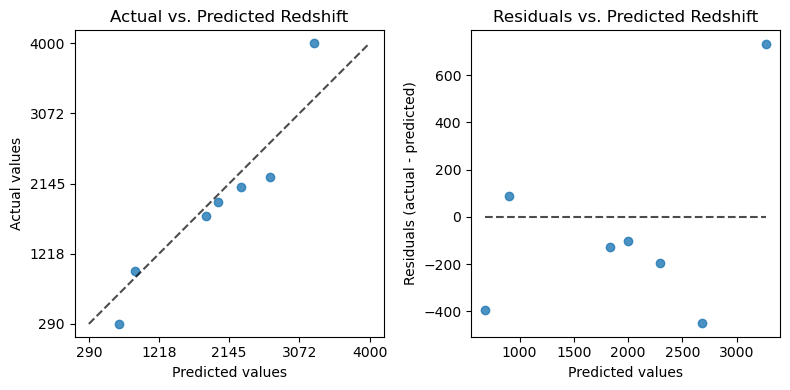

In [19]:
display_prediction_error(y_test=y_test, y_pred=y_pred.reshape(-1))

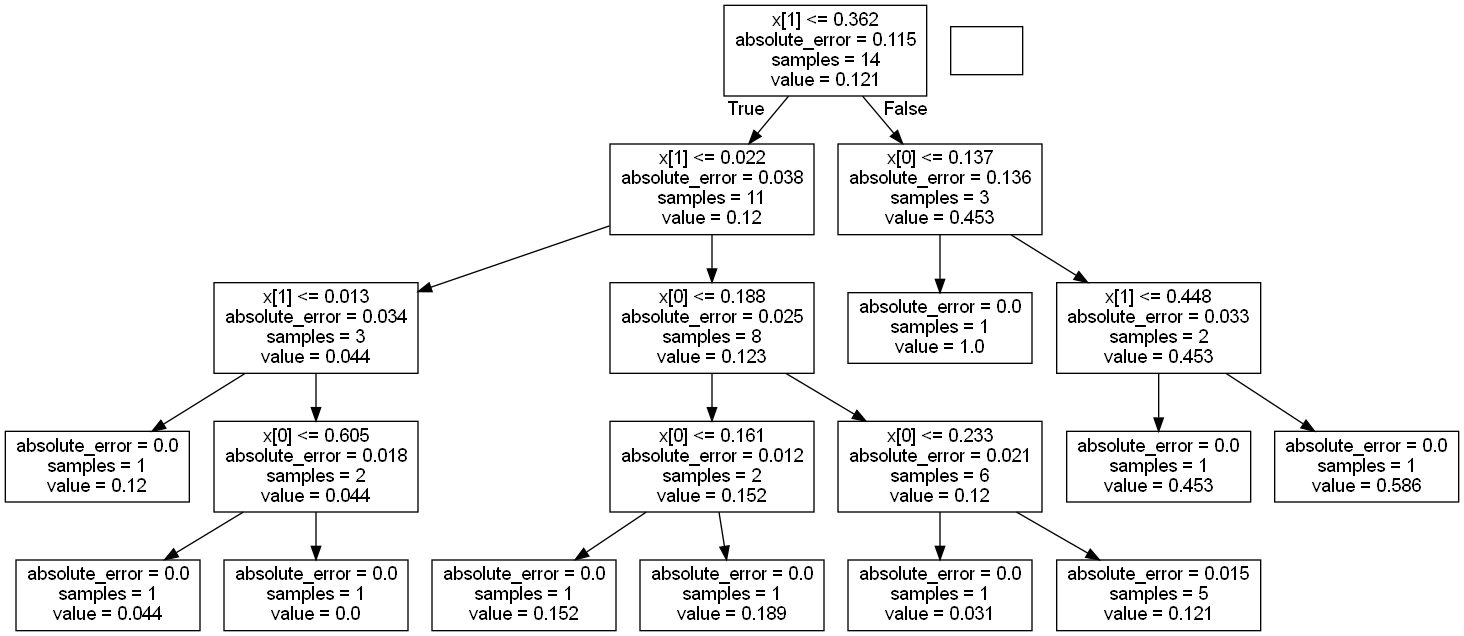

In [20]:
def get_tree(forest, i = 0):
    os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
    dot_data = six.StringIO()
    export_graphviz(forest.estimators_[i], out_file=dot_data)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    return Image(graph.create_png())

def sample_tree(forest):
    os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
    dot_data = six.StringIO()
    export_graphviz(forest.estimators_[random.randrange(0, len(forest.estimators_))], out_file=dot_data)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

sample_tree(model4)

<b>Support Vector Machine

In [21]:
search_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1],
    'C': [0.1, 0.5, 1, 5]
}

sv = SVR()

grid_search = GridSearchCV(estimator=sv, param_grid=search_grid, cv=RepeatedKFold(n_splits=3, n_repeats=5, random_state=13), verbose=2, n_jobs=-1)

grid_search.fit(train_X_norm, train_y_norm)

grid_search.best_params_

Fitting 15 folds for each of 64 candidates, totalling 960 fits


c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 5, 'gamma': 1, 'kernel': 'rbf'}

In [22]:
sv_model1 = grid_search.best_estimator_

sv_model1.fit(train_X_norm, train_y_norm)

y_pred = y_scaler.inverse_transform(sv_model1.predict(test_X_norm).reshape(-1, 1))

print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 4)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 4)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 4)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred), 3))

Mean absolute error = 391.9296
Mean squared error = 229193.6144
Median absolute error = 251.5971
Explain variance score = 0.83
R2 score = 0.8


c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


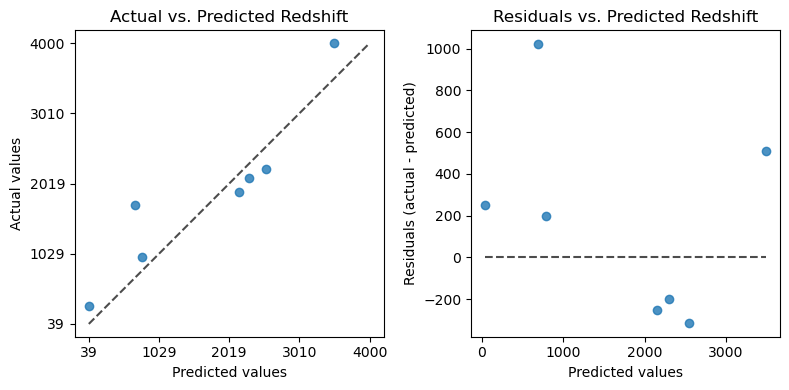

In [23]:
display_prediction_error(y_test=y_test, y_pred=y_pred.reshape(-1))

In [24]:
gammas = np.arange(1, 5, 0.005)
gamma_RSMEs = list()

best_gamma_ = 0
best_gamma_RSME = 1
for gamma in gammas:
    RSME = calculate_RSME(SVR(gamma=gamma, C=1), train_X_norm, train_y_norm, RepeatedKFold(n_splits=3, n_repeats=5, random_state=13))
    if RSME < best_gamma_RSME:
        best_gamma_ = gamma
        best_gamma_RSME = RSME
    gamma_RSMEs.append(RSME)

best_gamma_

2.369999999999971

In [25]:
best_gamma_RSME

0.12351930091589977

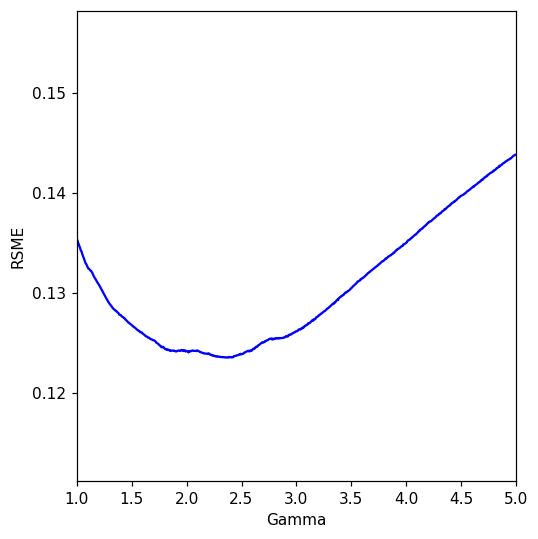

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi = 110)

ax.plot(gammas, gamma_RSMEs, color="blue")

ax.set_xlim(1, 5)
ax.set_ylim(min(gamma_RSMEs) * 0.9, max(gamma_RSMEs) * 1.1)

ax.set_xlabel("Gamma")
ax.set_ylabel("RSME")

plt.tight_layout()
plt.show()

In [27]:
sv_model2 = SVR(gamma=best_gamma_, C=10)

sv_model2.fit(train_X_norm, train_y_norm)

y_pred = y_scaler.inverse_transform(sv_model2.predict(test_X_norm).reshape(-1, 1))

print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 4))
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 4))
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 4))
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_pred), 3))

Mean absolute error = 230.9456
Mean squared error = 68971.2251
Median absolute error = 213.9277
Explain variance score = 0.94
R2 score = 0.94


c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


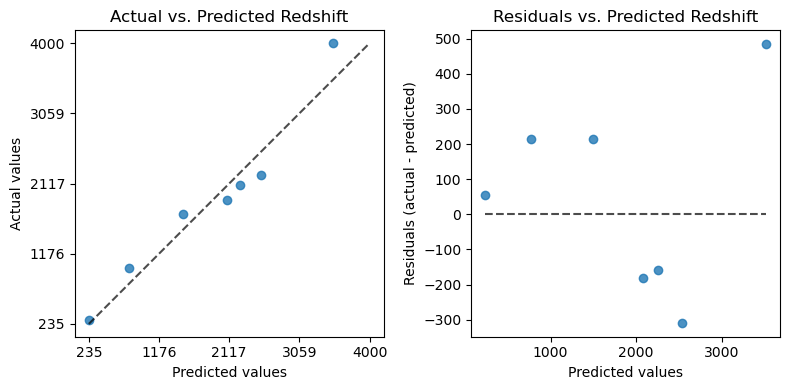

In [28]:
display_prediction_error(y_test=y_test, y_pred=y_pred.reshape(-1))

<b>Bayesian Ridge

In [29]:
search_grid = {
    'alpha_init': np.arange(0.1, 1.9, 0.05),
    'lambda_init': np.logspace(-9, 9, num=30)
    }

br = BayesianRidge()

grid_search = GridSearchCV(estimator=br, param_grid=search_grid, cv=RepeatedKFold(n_splits=3, n_repeats=5, random_state=13), verbose=2, n_jobs=-1)

grid_search.fit(train_X_norm, train_y_norm)

grid_search.best_params_

Fitting 15 folds for each of 1080 candidates, totalling 16200 fits


c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'alpha_init': 0.5000000000000001, 'lambda_init': 0.006723357536499335}

In [30]:
br_model1 = grid_search.best_estimator_

br_model1.fit(train_X_norm, train_y_norm)

y_pred = y_scaler.inverse_transform(br_model1.predict(test_X_norm).reshape(-1, 1))

print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 4)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 4)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 4)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred), 3))

Mean absolute error = 468.1107
Mean squared error = 244025.9668
Median absolute error = 472.7327
Explain variance score = 0.81
R2 score = 0.787


c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


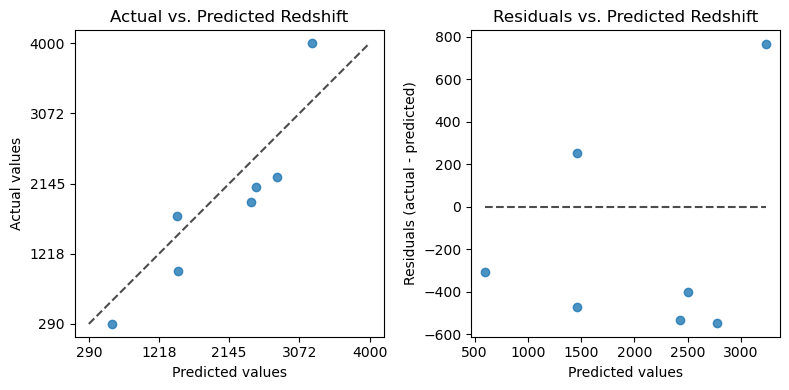

In [31]:
display_prediction_error(y_test=y_test, y_pred=y_pred.reshape(-1))

<b>K Neighbors

In [32]:
kn_model1 = KNeighborsRegressor()

kn_model1.fit(train_X_norm, train_y_norm)

y_pred = y_scaler.inverse_transform(kn_model1.predict(test_X_norm).reshape(-1, 1))

print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 4))
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 4))
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 4))
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_pred), 3))

Mean absolute error = 391.1429
Mean squared error = 221532.0
Median absolute error = 380.0
Explain variance score = 0.81
R2 score = 0.807


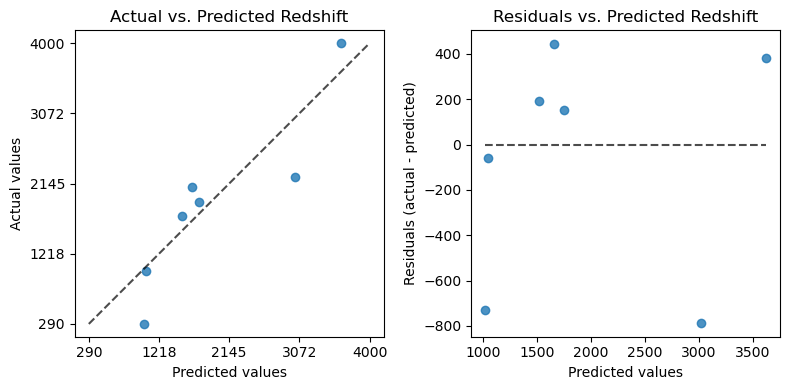

In [33]:
display_prediction_error(y_test=y_test, y_pred=y_pred.reshape(-1))

<h1>Using Best Support Vector to Predict O3_ALL

In [37]:
best_model = sv_model2

In [38]:
O3_all = pd.read_csv("../Data/real_events_O3_ALL.csv")
O3_all = O3_all[["eventid", "chirp_mass", "combined_far", "mass1", "mass2", "snr", "spin1z", "spin2z", "template_duration", "chisq", "likelihood"]]
O3_all["group"] = np.array([3 for _ in range(O3_all["eventid"].size)])
O3_all["group_name"] = np.array(["O" + str(group) for group in O3_all["group"]])
O3_all = O3_all.rename(columns={"combined_far": "far"})

O3_all["total_mass"] = O3_all["mass1"] + O3_all["mass2"]
O3_all["mass_ratio"] = O3_all["mass1"] / O3_all["mass2"]
O3_all["mass_dos"] = abs(O3_all["mass2"] - O3_all["mass1"]) / O3_all["total_mass"]

In [39]:
O3_all["luminosity_distance"] = y_scaler.inverse_transform(best_model.predict(X_scaler.transform(O3_all[["snr", "total_mass"]])).reshape(-1, 1))

In [41]:
O3_all.to_csv('../Data/O3_ALL_predicted.csv')

In [64]:
O3_mock_data = np.array(np.meshgrid(np.arange(0, 21, 1), np.arange(10, 201, 1))).T.reshape(-1,2)

O3_mock_df = pd.DataFrame()
O3_mock_df["snr"] = O3_mock_data[:,0]
O3_mock_df["total_mass"] = O3_mock_data[:,1]

In [72]:
best_model.predict(X_scaler.transform(O3_mock_df)).reshape(-1, 1)

array([[0.46139714],
       [0.46800449],
       [0.47484167],
       ...,
       [0.38066188],
       [0.38347533],
       [0.3862551 ]])

In [74]:
O3_mock_df["luminosity_distance"] = y_scaler.inverse_transform(best_model.predict(X_scaler.transform(O3_mock_df)).reshape(-1, 1))

In [75]:
O3_mock_df

,snr,total_mass,luminosity_distance
0,0,10,3459.044699
1,0,11,3503.710323
2,0,12,3549.929658
3,0,13,3597.693944
4,0,14,3646.992401
...,...,...,...
4006,20,196,2874.586332
4007,20,197,2894.035835
4008,20,198,2913.274311
4009,20,199,2932.293228


In [76]:
O3_mock_df.to_csv('../Data/O3_mock.csv')